# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64

from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close

In [3]:
%run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [14]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_139652\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4348.92,1.00,-131.89,2164.00,2032.11
OMUSDT,526.32,2940.68,0.68,0.00,2414.36,2414.36
BTCUSDT,601.02,745.75,0.17,3.54,144.73,148.27
SOLUSDT,281.20,230.97,0.05,0.00,-50.23,-50.23
JASMYUSDT,387.46,164.64,0.04,0.00,-222.81,-222.81
ETHUSDT,250.75,136.95,0.03,0.00,-113.80,-113.80
TRXUSDT,76.87,114.21,0.03,-10.72,37.34,26.62
BBUSDT,60.18,14.64,0.00,-39.73,-45.53,-85.26
BNBUSDT,1.14,1.08,0.00,-10.61,-0.06,-10.67
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

476

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 23d1df6166f4eea6051333a945d24fcfd3d44779)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 84efda68f733c7d7276988dce88e505ec048a027)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-16    2210.019473
2025-03-17    2353.886859
2025-03-18    2355.780860
2025-03-19    2369.599362
2025-03-20    2311.994731
Name: Total, Length: 179, dtype: float64

In [43]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-16      7.249559
2025-03-17    143.867386
2025-03-18      1.894001
2025-03-19     13.818502
2025-03-20    -57.604631
Name: Total, Length: 179, dtype: float64

In [44]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-217.91282855557566, -334.9272908594338)

In [45]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [46]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [47]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [48]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [49]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [50]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [51]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

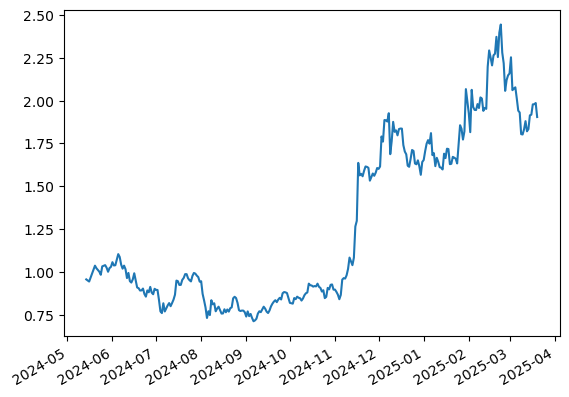

In [52]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

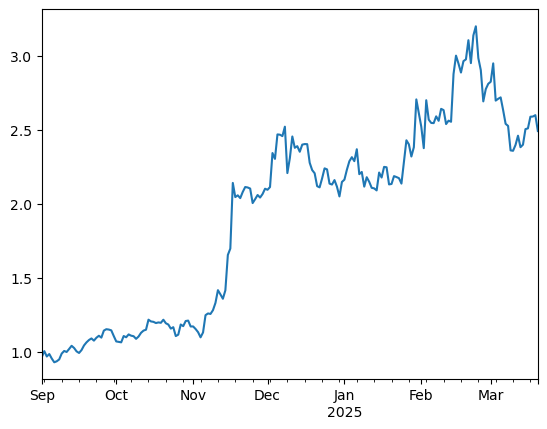

In [53]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [55]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [58]:
days=30
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [59]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [62]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
ADAUSDT,0.7625
TIAUSDT,0.2375
LTCUSDT,0.0000
AVAXUSDT,0.0000
DOGEUSDT,0.0000
QNTUSDT,0.0000
BNBUSDT,0.0000
ETHUSDT,0.0000
THETAUSDT,0.0000
SANDUSDT,0.0000


In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
TIAUSDT,0.7
BTCUSDT,0.3


In [64]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

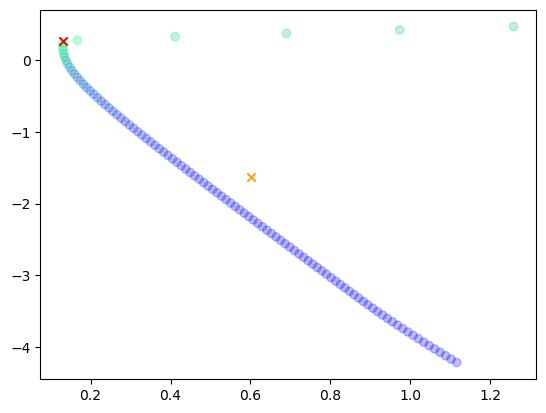

In [65]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [66]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [67]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2940.675519,0.676185,0.0000,0.676185
BTCUSDT,745.750880,0.171480,0.0000,0.171480
SOLUSDT,230.967160,0.053109,0.0000,0.053109
JASMYUSDT,164.644646,0.037859,0.0000,0.037859
ETHUSDT,136.946918,0.031490,0.0000,0.031490
TRXUSDT,114.211879,0.026262,0.0000,0.026262
BBUSDT,14.644654,0.003367,0.0000,0.003367
BNBUSDT,1.077919,0.000248,0.0000,0.000248
PEPEUSDT,0.000002,0.000000,0.0000,0.000000
PAXGUSDT,0.000000,0.000000,0.9745,-0.974500


### Current results

In [69]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [70]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,1.0


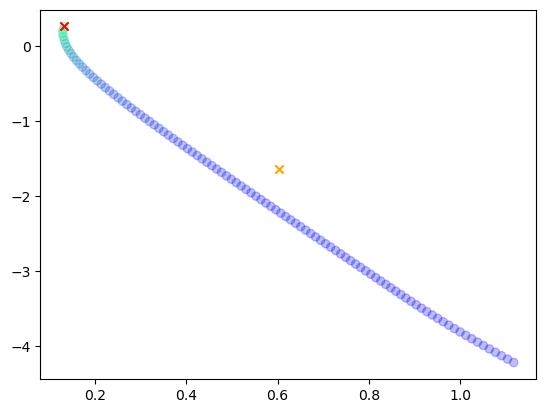

In [71]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [72]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,2940.675519,0.676185,0.0,0.676185
BTCUSDT,745.750880,0.171480,0.0,0.171480
SOLUSDT,230.967160,0.053109,0.0,0.053109
JASMYUSDT,164.644646,0.037859,0.0,0.037859
ETHUSDT,136.946918,0.031490,0.0,0.031490
TRXUSDT,114.211879,0.026262,0.0,0.026262
BBUSDT,14.644654,0.003367,0.0,0.003367
BNBUSDT,1.077919,0.000248,0.0,0.000248
PEPEUSDT,0.000002,0.000000,0.0,0.000000
PAXGUSDT,0.000000,0.000000,1.0,-1.000000


# Risk Reward Analysis

In [74]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [75]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

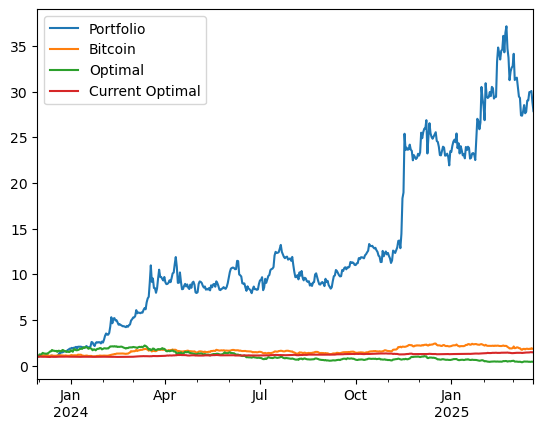

In [76]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [77]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

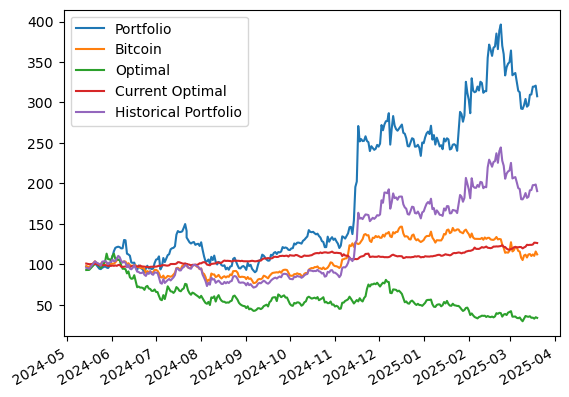

In [78]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [79]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-11,296.695564,110.822138,32.836992,120.792747,183.215484
2025-03-12,304.273202,111.816046,36.061755,121.698183,187.971314
2025-03-13,294.723724,108.335893,35.400297,124.030342,182.047066
2025-03-14,296.584579,112.099402,35.069981,123.740890,183.335317
2025-03-15,309.438075,112.572571,35.719041,123.988454,191.350939
2025-03-16,309.820279,110.193184,33.842438,123.947145,191.748673
2025-03-17,319.421446,112.092354,34.031408,124.359478,197.754476
2025-03-18,319.598637,110.351014,32.742498,126.651129,197.858229
2025-03-19,320.732229,115.728906,34.510758,126.527184,198.556312
2025-03-20,307.605515,112.180303,33.715055,126.237790,190.373258


## Volatilities

In [81]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.980151
 dtype: float64,
 0.9801512297997222)

In [82]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.602662
 dtype: float64,
 0.6026624353795339)

In [83]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.885345
Bitcoin            0.434325
Optimal            0.796886
Current Optimal    0.128709
dtype: float64

In [84]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4164852879166706

In [85]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-2.105814098024455

In [86]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

-2.7098468959794

## Risk Contribution

In [88]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.043793,0.3,0.275122,0.11211,0.032919,0.079192
TIAUSDT,-0.024958,0.7,0.724878,0.88789,0.808698,0.079192


In [89]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
PAXGUSDT,0.030154,1.0,1.0,1.0,1.0,0.0


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,-0.130372,0.68,0.685801,0.704689,0.554595,0.150094
BTCUSDT,-0.024816,0.17,0.181154,0.125787,0.027960,0.097827
SOLUSDT,-0.015293,0.05,0.043306,0.072548,0.010809,0.061739
JASMYUSDT,-0.017669,0.04,0.027863,0.053400,0.005493,0.047907
ETHUSDT,-0.009162,0.03,0.026001,0.031719,0.001829,0.029890
TRXUSDT,-0.001249,0.03,0.035874,0.011857,0.000552,0.011306


# Value At Risk

## Historical

### Optimal Weights

In [94]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.09507316087006767, -0.1361587893379351)

### Current Weights

In [96]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.06992740168725695, -0.07850320433095327)

In [97]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [98]:
var=historical_var.iloc[row]
var

OMUSDT      -0.038577
BTCUSDT     -0.008520
SOLUSDT     -0.008456
JASMYUSDT   -0.006443
ETHUSDT     -0.003448
TRXUSDT     -0.000728
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.066172
Name: 2025-02-24 00:00:00, dtype: float64

In [99]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.047166
BTCUSDT     -0.010802
SOLUSDT     -0.007706
JASMYUSDT   -0.004377
ETHUSDT     -0.003394
TRXUSDT     -0.000947
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.074393
dtype: float64

## Parametric

### Optimal Weights

In [102]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.10155938809987801, -0.13017105592837477)

### Current Weights

In [104]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.062445494437051496, -0.08003785864529259)

## Multivariate

### Optimal Weights

In [107]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.10098852069011435, -0.12759527583027613)

### Current Weights

In [109]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0692956693685761, -0.0847969828616037)

In [110]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.049890
BTCUSDT     -0.008220
SOLUSDT     -0.004621
JASMYUSDT   -0.003578
ETHUSDT     -0.002059
TRXUSDT     -0.000734
Portfolio   -0.069103
dtype: float64

In [111]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.049515
BTCUSDT     -0.008140
SOLUSDT     -0.005296
JASMYUSDT   -0.003699
ETHUSDT     -0.002147
TRXUSDT     -0.000939
Portfolio   -0.069736
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [115]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10125145953921537, -0.126690457525171)

### Current Weights

In [117]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06906497098801691, -0.08433919154883368)

In [118]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [121]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10173862459808565, -0.1255475812422902)

### Current Weights

In [123]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07159109449852484, -0.08694316936420866)

In [124]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [127]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.20040268321677224, -0.2824576561185456)

### Current Weights

In [129]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11419074222780272, -0.15657545369340942)

In [130]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [133]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [134]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10191648524574323, -0.12790021585922767)

### Current Weights

In [136]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06162436846803742, -0.07686958111522835)

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [138]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.104883,-0.046999,-0.044363,-0.049890,-0.048187
BTCUSDT,-0.003334,-0.008985,-0.007958,-0.008220,-0.009449
SOLUSDT,-0.001347,-0.005509,-0.004673,-0.004621,-0.005101
JASMYUSDT,-0.001860,-0.004266,-0.003627,-0.003578,-0.004008
ETHUSDT,-0.000827,-0.002353,-0.002037,-0.002059,-0.002356
TRXUSDT,-0.000350,-0.000756,-0.000691,-0.000734,-0.000741
Portfolio,-0.112600,-0.068868,-0.063350,-0.069103,-0.069841


In [139]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.108469,-0.048422,-0.044494,-0.049515,-0.047109
BTCUSDT,-0.001857,-0.008601,-0.008202,-0.008140,-0.010192
SOLUSDT,-0.000572,-0.005182,-0.004963,-0.005296,-0.005699
JASMYUSDT,-0.002221,-0.004254,-0.003642,-0.003699,-0.004259
ETHUSDT,-0.000348,-0.002291,-0.002054,-0.002147,-0.002563
TRXUSDT,-0.000670,-0.000807,-0.000609,-0.000939,-0.000735
Portfolio,-0.114136,-0.069557,-0.063963,-0.069736,-0.070558


## VaR Violation

In [141]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.067089,-0.137660,-0.132826,-0.024770
2024-01-15,-0.067089,-0.138388,-0.127012,0.041233
2024-01-16,-0.067089,-0.137534,-0.127220,-0.002836
2024-01-17,-0.067089,-0.138365,-0.128216,-0.027904
2024-01-18,-0.061383,-0.137346,-0.130238,-0.058833
...,...,...,...,...
2025-03-17,-0.147467,-0.142194,-0.144057,0.005584
2025-03-18,-0.147467,-0.143039,-0.140988,-0.037874
2025-03-19,-0.147467,-0.144604,-0.146130,0.054005
2025-03-20,-0.147467,-0.144373,-0.144317,-0.023057


In [142]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.044762,-0.083333,-0.081488,-0.014994
2024-05-29,-0.044762,-0.081264,-0.079578,-0.007107
2024-05-30,-0.044762,-0.071546,-0.069753,0.025376
2024-05-31,-0.044762,-0.075514,-0.072606,0.048170
2024-06-01,-0.044762,-0.082165,-0.075314,0.065759
...,...,...,...,...
2025-03-17,-0.081311,-0.081871,-0.089069,0.030989
2025-03-18,-0.060590,-0.065732,-0.068689,0.000555
2025-03-19,-0.060590,-0.065665,-0.070166,0.003547
2025-03-20,-0.061422,-0.069415,-0.073709,-0.040927


<Axes: >

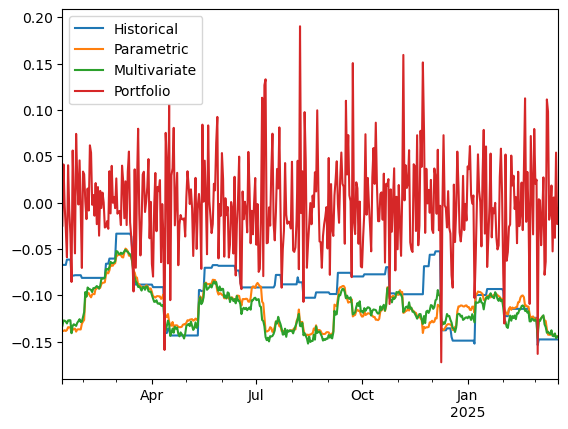

In [143]:
var_data.plot()

<Axes: >

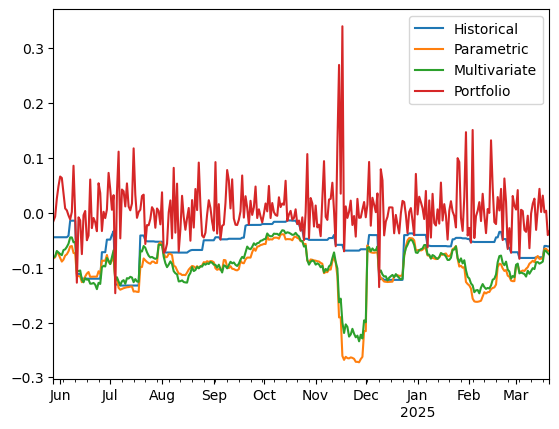

In [144]:
current_var_data.plot()

In [145]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.034642,0.013857,0.013857
Kupiec Stat,2.398273,16.489049,16.489049
P-value,0.121469,0.000049,0.000049


In [146]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.063758,0.013423,0.010067
Kupiec Stat,1.096622,11.693855,14.676853
P-value,0.295009,0.000627,0.000128


# Principal Component Analysis

## Historical PCA

In [149]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.86075616+0.j, 0.05988259+0.j, 0.03716408+0.j, 0.02247001+0.j,
       0.01972715+0.j])

In [150]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.020503-0.000000j
ADAUSDT      0.034770-0.000000j
ALGOUSDT     0.020823-0.000000j
APTUSDT      0.015789-0.000000j
ARBUSDT      0.020312-0.000000j
ATOMUSDT     0.016248-0.000000j
AVAXUSDT     0.021533-0.000000j
BCHUSDT      0.013148-0.000000j
BNBUSDT      0.009063-0.000000j
BONKUSDT     0.023892-0.000000j
BTCUSDT      0.011123-0.000000j
CAKEUSDT     0.018114-0.000000j
DEXEUSDT     0.003664-0.000000j
DOGEUSDT     0.021534-0.000000j
DOTUSDT      0.015303-0.000000j
EOSUSDT      0.017464-0.000000j
ETCUSDT      0.015086-0.000000j
ETHUSDT      0.016938-0.000000j
FDUSDUSDT    0.000065-0.000000j
FETUSDT      0.022332-0.000000j
FILUSDT      0.017722-0.000000j
FLOWUSDT     0.016409-0.000000j
GALAUSDT     0.021036-0.000000j
GRTUSDT      0.018197-0.000000j
HBARUSDT     0.015433-0.000000j
ICPUSDT      0.017028-0.000000j
IMXUSDT      0.018136-0.000000j
INJUSDT      0.021541-0.000000j
IOTAUSDT     0.024403-0.000000j
JASMYUSDT    0.022623-0.000000j
LDOUSDT      0.022517-0.000000j
LINKUSDT

C:\Users\niroo\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\niroo\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: >

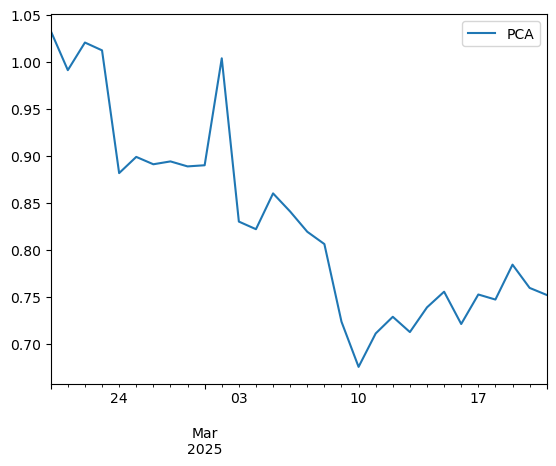

In [151]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

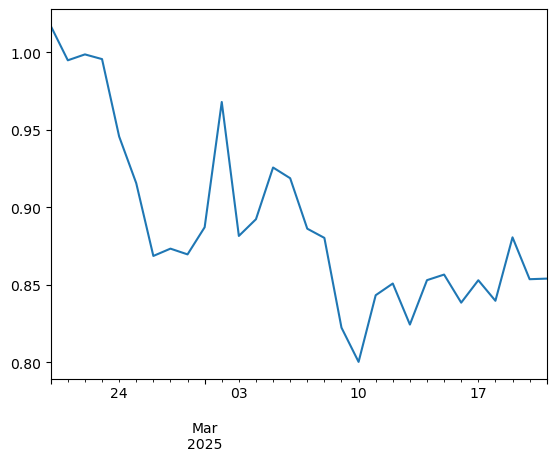

In [152]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000+0.000000j
VETUSDT      0.057635+0.000000j
XTZUSDT      0.071019+0.000000j
SANDUSDT     0.071210+0.000000j
GRTUSDT      0.073828+0.000000j
FLOWUSDT     0.077781+0.000000j
ARBUSDT      0.085468+0.000000j
ICPUSDT      0.086623+0.000000j
THETAUSDT    0.088936+0.000000j
FILUSDT      0.090768+0.000000j
DOGEUSDT     0.094396+0.000000j
GALAUSDT     0.097093+0.000000j
ALGOUSDT     0.106316+0.000000j
STXUSDT      0.109285+0.000000j
WBETHUSDT    0.113028+0.000000j
ETHUSDT      0.114054+0.000000j
LINKUSDT     0.125798+0.000000j
JASMYUSDT    0.130232+0.000000j
AVAXUSDT     0.130591+0.000000j
ETCUSDT      0.135425+0.000000j
dtype: complex128

C:\Users\niroo\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\niroo\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: >

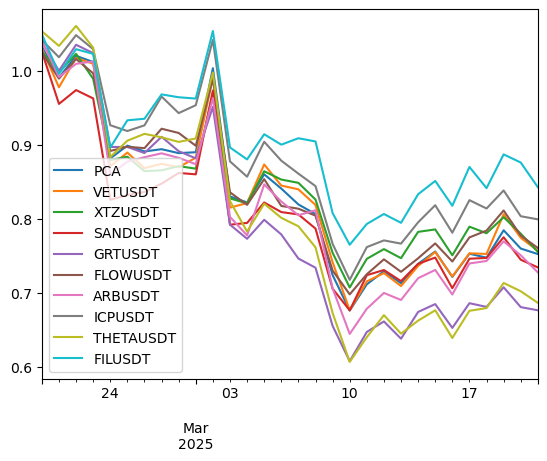

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

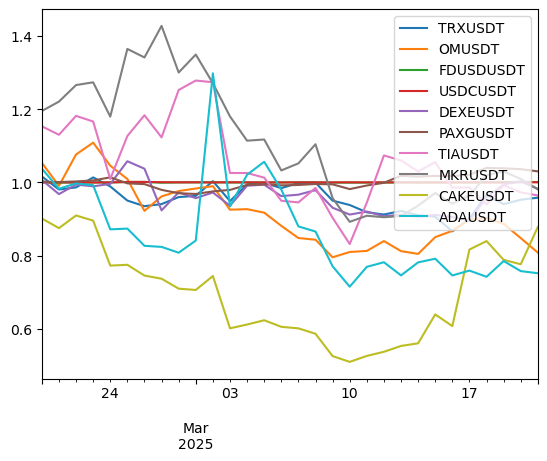

In [155]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [157]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.83728699, 0.06661713, 0.04712471, 0.0288102 , 0.02016097])

In [158]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.053298
BTCUSDT      0.076369
SOLUSDT      0.171790
JASMYUSDT    0.159346
ETHUSDT      0.116555
TRXUSDT      0.033457
BBUSDT       0.155377
BNBUSDT      0.063437
PEPEUSDT     0.170049
PAXGUSDT     0.000322
Name: PC1, dtype: float64

<Axes: >

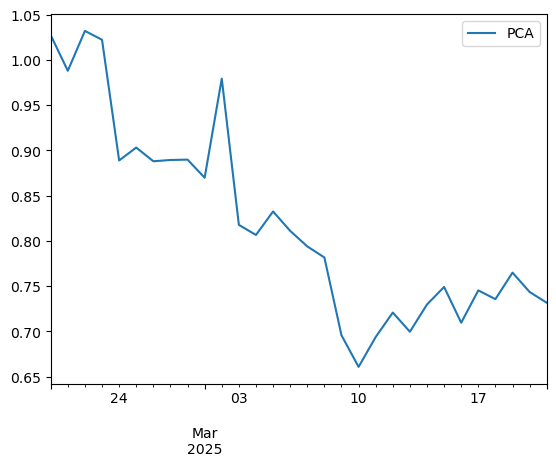

In [159]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

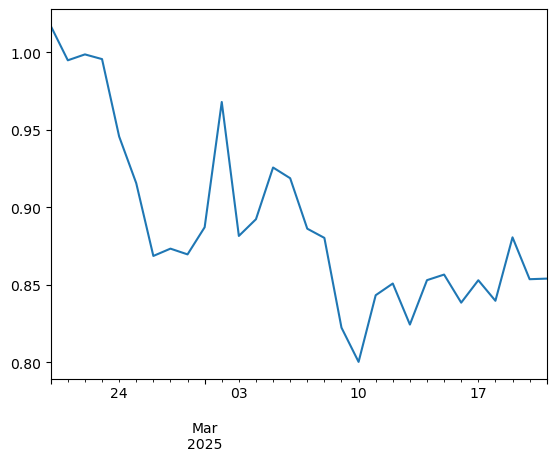

In [160]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [161]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
JASMYUSDT    0.124068
ETHUSDT      0.125443
PEPEUSDT     0.166180
BBUSDT       0.167068
BTCUSDT      0.169189
SOLUSDT      0.181738
BNBUSDT      0.200817
OMUSDT       0.265926
TRXUSDT      0.275617
dtype: float64

<Axes: >

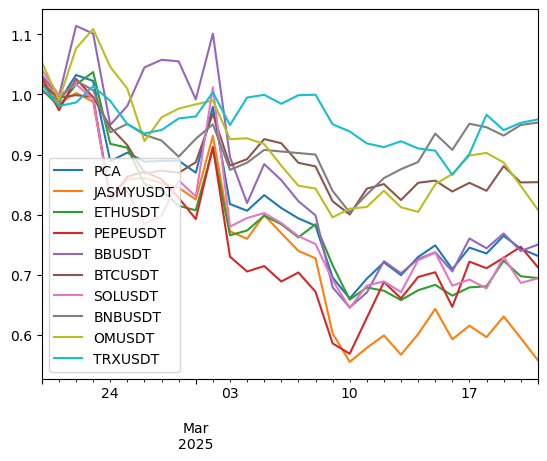

In [162]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [164]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.863382
BBUSDT       1.571875
JASMYUSDT    1.379257
SOLUSDT      1.244661
ETHUSDT      1.014352
BTCUSDT      1.000000
OMUSDT       0.868257
BNBUSDT      0.659802
TRXUSDT      0.331654
PAXGUSDT     0.037170
Name: BTCUSDT, dtype: float64

In [165]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.845062
JASMYUSDT    1.565295
PEPEUSDT     1.514796
BBUSDT       1.336711
ETHUSDT      1.302785
BTCUSDT      1.000000
BNBUSDT      0.595294
OMUSDT       0.574694
TRXUSDT      0.335316
PAXGUSDT     0.023486
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [167]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [168]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.198258+0.000000j
BNBUSDT,0.181178+0.000000j
ETHUSDT,0.178445+0.000000j
BBUSDT,0.169495+0.000000j
JASMYUSDT,0.158362+0.000000j
SOLUSDT,0.157628+0.000000j
TRXUSDT,0.059604+0.000000j
PEPEUSDT,0.056728+0.000000j
OMUSDT,-0.065064+0.000000j
PAXGUSDT,-0.070560+0.000000j


### Regression to PCA

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

C:\Users\niroo\anaconda3\Lib\site-packages\pandas\core\internals\managers.py:1753: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr


1.1788236469581874

In [171]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

C:\Users\niroo\anaconda3\Lib\site-packages\pandas\core\internals\managers.py:1753: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr


BTCUSDT      2.757862
ETHUSDT      2.193967
SOLUSDT      1.964194
BNBUSDT      1.962157
PCA          1.000000
PEPEUSDT     0.854631
JASMYUSDT    0.813270
BBUSDT       0.622031
TRXUSDT      0.337514
OMUSDT       0.298060
PAXGUSDT     0.270247
dtype: float64

In [172]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

C:\Users\niroo\anaconda3\Lib\site-packages\pandas\core\internals\managers.py:1753: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr


BNBUSDT      1.389658
BTCUSDT      1.372953
PCA          1.000000
ETHUSDT      0.995144
TRXUSDT      0.926197
JASMYUSDT    0.786946
BBUSDT       0.710094
OMUSDT       0.694487
SOLUSDT      0.678148
PEPEUSDT     0.677983
PAXGUSDT     0.229058
dtype: float64

### Correlation Matrix

<Axes: >

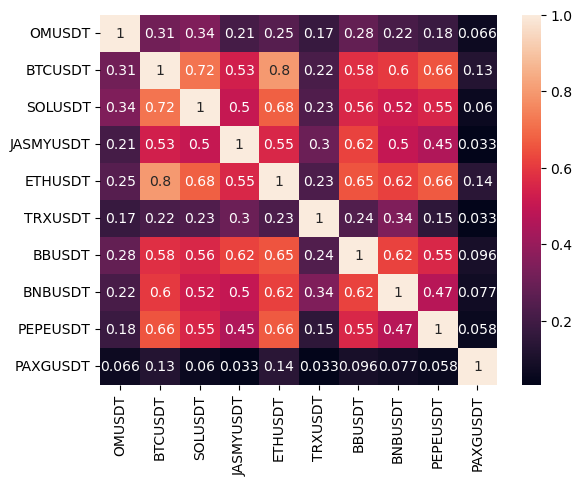

In [174]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

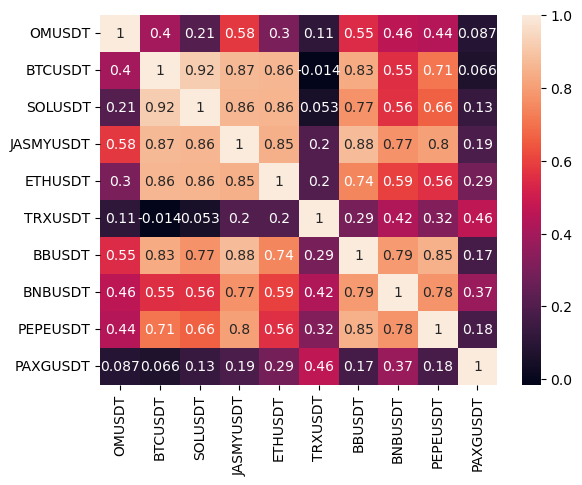

In [175]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [176]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [177]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

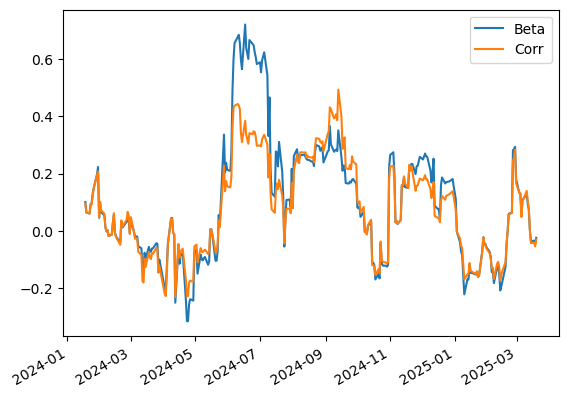

In [178]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [180]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [181]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-13,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.079350,0.0
2024-09-12,0.027662,0.005115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.110130,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-12,0.000000,0.002026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.290641,0.021574,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-11,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-11,0.087482,0.011826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.024024,0.226592,0.0
2025-01-10,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-02-09,0.000000,0.002012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-03-11,0.000000,0.595480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-03-21,0.000000,0.002017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [182]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

FDUSDUSDT    0.883907
PAXGUSDT     0.072070
SHIBUSDT     0.021600
DOTUSDT      0.011279
CAKEUSDT     0.004897
DEXEUSDT     0.004233
Name: 2025-03-21 00:00:00, dtype: float64

In [183]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
